In [2]:
#!pip install torch
#!pip install sklearn
import torch.nn as nn
import sklearn
import torch
import pickle
import os
from torch.autograd import Variable

## Modèle :
On crée nos différents modèles

In [125]:
camem.config.hidden_size

768

In [3]:
class Simple_Classifier(nn.Module):
    def __init__(self, hidden_size):
        super(Simple_Classifier, self).__init__()
        self.linear1 = nn.Linear(hidden_size, 1)
        self.relu=nn.ReLU()

    def forward(self, x):#, mask_cls):
        h = self.linear1(x).squeeze(-1)
        sent_scores = self.relu(h) #* mask_cls.float()
        return sent_scores

class Multi_Linear_Classifier(nn.Module):
    def __init__(self, hidden_size):
        super(Multi_Linear_Classifier, self).__init__()
        self.linear1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.linear2 = nn.Linear(int(hidden_size/2),int(hidden_size/6))
        self.linear3 = nn.Linear(int(hidden_size/6),1)
        self.Lrelu=nn.LeakyReLU(negative_slope= 0.01)

    def forward(self, x):#, mask_cls):
        h = self.linear1(x).squeeze(-1)
        h = self.Lrelu(h) #* mask_cls.float()
        h = self.linear2(h)
        h = self.Lrelu(h)
        h = self.linear3(h)
        h = self.Lrelu(h)
        return h
    

class SMHA_classifier(nn.Module):
    def __init__(self, size,nhead):
        super(SMHA_classifier, self).__init__()
        self.MHA = nn.MultiheadAttention(size[1], nhead)
        self.LReLu=nn.LeakyReLU(negative_slope= 0.01)
        self.sigmoid = nn.Sigmoid()
        self.LN=nn.LayerNorm(size)

    def forward(self, x):#, mask_cls):
        h,weights = self.MHA(x,x,x)
        normalized_h=self.LN(h)     
        sent_scores = self.LReLu(normalized_h) #* mask_cls.float()
        return sent_scores    
    
def select_sent(phrase,clss,K=3):
    index_phrase=torch.topk(phrase,K)[1]
    pred_phrase=torch.zeros(clss.shape)
    index_1=[[clss[k].tolist().index(int(index_phrase[k][i])) 
                for i in range(len(index_phrase[k])) if int(index_phrase[k][i]) in clss[k].tolist()]
                 for k in range(K)]
    index_2=[[i] for i in range(K)]
    pred_phrase[index_2,index_1]=torch.ones(index_phrase.shape)
    return pred_phrase


from sklearn.metrics import confusion_matrix
def confusion_output(sent,output,clss_index):
    a=[confusion_matrix(output[i],sent[i]) for i in range(sent.shape[0])]
    c=[a[i][0][0]+a[i][1][1] for i in range(sent.shape[0])]
    score_total=[round((c[i]-(512-clss_index[i]))/(clss_index[i]),3) for i in range(sent.shape[0])]
    score_1=[(a[i][1][1])/3 for i in range(sent.shape[0])]
    return score_total,score_1


class Summarizer(nn.Module):
    def __init__(self, device,classif):#args, , load_pretrained_bert = False, bert_config = None):
        super(Summarizer, self).__init__()
        self.device = device
        self.bert =CamembertModel.from_pretrained("camembert-base")
        #BertModel.from_pretrained('bert-base-uncased')
        #Bert(args.temp_dir, load_pretrained_bert, bert_config)
        self.simple_classif = Simple_Classifier(self.bert.config.hidden_size)
        self.multi_classif = Multi_Linear_Classifier(self.bert.config.hidden_size)
        self.select_sent=select_sent
        self.softmax=nn.Softmax()
        self.attclassif=SMHA_classifier(torch.Size([self.bert.config.max_position_embeddings-2,self.bert.config.hidden_size]),8)
        self.loss=nn.functional.binary_cross_entropy
        self.classif_type=classif
        # self.score=confusion_output
        self.to(device)

    def forward(self,x,mask, mask_cls):#,clss,output,k=3):#,segs):#, sentence_range=None): #segs, 
        #x input_ids
        #Segs = Segment pour phrases (0 ou 1), marche pas dans un RoBERTa
        #clss index du début des phrases 
        #mask_cls vecteur pour passer de l'embedding au cls, en gros sélectionne le bon index des vecteurs de l'embedding qu'on va utiliser pour faire la classif
        top_vec= self.bert(x, mask)#, segs)
        # sents_vec=self.sent_vec(last,clss)

        # sents_vec = top_vec[0][torch.arange(top_vec[0].size(0)).unsqueeze(1), clss]
        # sents_vec = sents_vec * mask_cls[:, :, None].float()
        if self.classif_type=='simple_linear':
            sent_scores = self.simple_classif(top_vec.last_hidden_state).squeeze(-1)#, mask_cls
        elif self.classif_type=='multi_linear':
            sent_scores = self.multi_classif(top_vec.last_hidden_state).squeeze(-1)
        elif self.classif_type=='attention':
            sent_scores = self.attclassif(top_vec.last_hidden_state)
            sent_scores=sent_scores.mean(dim=2)
        else:
            raise ValueError("Attention, veuillez bien spécifier un type de classifieur.\nSeules les valeurs 'simple_linear', 'multi_linear' ou 'attention' sont acceptées.")
        #sent_scores_masked = torch.mul(sent_scores,mask_cls)
        #sent_scores_masked = self.select_sent(sent_scores_masked,clss,K=k)
        #sent_scores_masked=
        
        # score=self.score(sent_scores,output)
        return sent_scores#_masked#,sent_scores,top_vec.last_hidden_state#,score#, mask_cls

On installe et charge le modèle Camembert

In [ ]:
!pip install transformers

In [4]:
from transformers import CamembertModel,BertModel,RobertaModel,AdamW
camem=CamembertModel.from_pretrained("camembert-base")
camem.config.hidden_size

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768

In [ ]:
camem.config

## Score 
On crée nos fonctions de score : précision, rappel et score F1

In [5]:
class F1_score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self):#, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """

        #self.average = average
        #if average not in [None, 'micro', 'macro', 'weighted']:
         #   raise ValueError('Wrong value of average parameter')
    @staticmethod
    def true_positive_mean(x,y) -> torch.tensor:
        '''
        Caclul le nombre moyen de vrai positif de la prediction x par rapport aux labels y (binaires).
        '''
        tp=torch.mul(x,y).sum()
        tpm=torch.div(tp,y.shape[0])
        return tpm
    @staticmethod
    def false_positive_mean(x,y) -> torch.tensor:
        '''
        Caclul le nombre moyen de faux négatif de la prediction x par rapport aux labels y (binaires).
        '''
        device=y.device
        fp=torch.sub(x,y)
        fp=torch.max(fp,torch.tensor([0.]).to(device))
        fp=fp.sum().float()
        fpm=torch.div(fp,y.shape[0])
        return fpm
    @staticmethod
    def false_negative_mean(x,y) -> torch.tensor:
        '''
        Caclul le nombre moyen de faux négatif de la prediction x par rapport aux labels y (binaires).
        '''
        fn=torch.sub(y,x)
        device=y.device
        fn=torch.max(fn,torch.tensor([0.]).to(device))
        fn=fn.sum().float()
        fnm=torch.div(fn,y.shape[0])
        return fnm
    #@staticmethod
    def precision(self,x,y) -> torch.tensor:
        device=y.device
        tp=self.true_positive_mean(x,y)
        fp=self.false_positive_mean(x,y)
        if (tp+fp)!=0:
            prec=torch.div(tp,(tp+fp))
            return prec
        else:
            return torch.tensor(0.).to(device)

    def recall(self,x,y) -> torch.tensor:
        tp=self.true_positive_mean(x,y)
        fn=self.false_negative_mean(x,y)
        rec=torch.div(tp,(tp+fn))
        return rec
    def __call__(self,x,y) -> torch.tensor:
        device=y.device
        rec=self.recall(x,y)
        prec=self.precision(x,y)
        f1=torch.mul(rec,prec)
        f1=torch.mul(2,f1)
        f1=torch.div(f1,prec+rec)
        if (prec+rec)!=0:
            return f1#prec,rec,
        else:
            return torch.tensor(0.).to(device)#prec,rec,

        
            

## Fonction de perte
On va maintenant définir notre fonction de perte

In [6]:
class Weighted_Loss:
    '''
    Fonction permettant de calculer la fonction de perte Mean Absolute Error mais pondérée par des poids.
    '''
    def __init__(self,weight,loss_type='L1'):
        '''
        On initialise notre fonction de perte :
        @weight : les poids que vous voulez pour chaque classe (dim=nombre de classe)
        '''
        self.weights=weight
        self.loss_type=loss_type
        
    def Weighted_L1(self,y_hat,y) -> torch.Tensor:
        '''
        On calcule la fonction :
        @y_hat : les prédictions du modèle
        @y : les vraies valeurs
        
        Attention, dim(y_hat)==dim(y)
        '''
        if y_hat.shape!=y.shape:
            raise ValueError("Attention, les deux inputs n'ont pas la même dimension !")
        device=y.device
        
        w=torch.repeat_interleave(torch.tensor(self.weights[0]),y.shape[1])
        w=w.repeat(y.shape[0],1)
        w[torch.arange(y.shape[0],dtype=torch.long).unsqueeze(1),torch.topk(y,3)[1]]=self.weights[1]
        sum_weights=w.sum()
        w=w.to(device)
        sum_weights=sum_weights.to(device)
        errors=torch.sub(y,y_hat)
        errors=torch.abs(errors)
        weighted_errors=torch.mul(w,errors)
        sum_weighted_errors=weighted_errors.sum()
        WMAE=torch.div(sum_weighted_errors,sum_weights)
        #WMAE.requires_grad=True
        return Variable(WMAE,requires_grad=True)#,sum_weighted_errors,sum_weights
    
    def Weighted_Sum(self,y_hat,y) -> torch.Tensor:
        '''
        Calcule la somme pondérée de la différence de la prédiction du modèle et du vecteur cible.
        '''
        if y_hat.shape!=y.shape:
            raise ValueError("Attention, les deux inputs n'ont pas la même dimension !")
        
        device_yhat=y_hat.device
        device_y=y.device
        if device_yhat!=device_y:
            y.to(device_yhat)
        
        w=torch.repeat_interleave(torch.tensor(self.weights[0]),y.shape[1])
        w=w.repeat(y.shape[0],1)
        w[torch.arange(y.shape[0],dtype=torch.long).unsqueeze(1),torch.topk(y,3)[1]]=self.weights[1]
        w=w.to(device_yhat)
        y_diff=y_hat-y
        y_diff_pond=torch.mul(y_diff,w)
        sum_y_diff_pon=-torch.div(torch.sum(y_diff_pond),y_hat.shape[0])
        return Variable(sum_y_diff_pon,requires_grad=True)
    
    def __call__(self,y_hat,y) -> torch.Tensor:
        if self.loss_type=='L1':
            loss=self.Weighted_L1(y_hat,y)
            return loss
        elif self.loss_type=='sum':
            loss=self.Weighted_Sum(y_hat,y)
            return loss
        else:
            raise ValueError("Attention, veuillez bien spécifier un type de perte.\nSeules les valeurs 'L1' ou 'sum' sont acceptées.")
        

In [93]:
x=torch.rand(100,14)
y=torch.rand(100,14)
loss=Weighted_Loss(weight=[torch.tensor(0.5),torch.tensor(1000.)],loss_type='sum')
print(loss(x,y))
perte=torch.nn.L1Loss()
print(perte(x,y))
print("On voit que la première est plus élevée que la deuxième, c'est ce que l'on cherche dans notre cas !")

tensor(1160.9480, requires_grad=True)
tensor(0.3357)
On voit que la première est plus élevée que la deuxième, c'est ce que l'on cherche dans notre cas !


<ipython-input-92-ccd817f21f9c>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w=torch.repeat_interleave(torch.tensor(self.weights[0]),y.shape[1])


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

y = Variable(torch.rand(2,10),requires_grad=True)#Variable(torch.rand(5, 3), requires_grad=True)
t = torch.rand(2,10)#Variable(torch.LongTensor(5).random_(0, 2))
m=Weighted_Loss(weight=[torch.tensor(0.5),torch.tensor(1000.)])
#m = nn.L1Loss()#MultiMarginLoss()
loss = m(y, t)
loss.backward()
print(y.grad)

## On prépare l'entraînement

On vérifie que du GPU est disponible

In [7]:
torch.cuda.is_available()

True

In [8]:
device = torch.device("cuda")

On charge nos données d'entraînement

In [9]:
train_dataset=pickle.load(open('train.pickle','rb'))

On crée notre dataloader, indispensable pour créer une boucle d'entraînement sous torch, on fixe notre taille de batch

In [138]:
summa.to('cpu'),input_id.to('cpu'),mask.to('cpu'),mask_cls.to('cpu'),output.to('cpu')
del summa,input_id,mask,mask_cls,output,dataloader
torch.cuda.empty_cache()

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size=8

dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

A ne lancer que si on veut ré-initialiser la mémoire sur GPU

In [ ]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f

On place le modèle sur GPU

In [11]:
training_stats = []
epochs=20
summa=Summarizer(device=device,classif='simple_linear')

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


On défini notre algorithme d'apprentissage

In [12]:
optimizer = AdamW(summa.parameters(),
                  lr = 2e-4, # Learning Rate
                  eps = 1e-3)# Epsilon

On défini notre score

In [13]:
score=F1_score()

On défini notre fonction de perte

In [128]:
alpha=0.001
weights=torch.Tensor([alpha*1/((512-3)/512),(1-alpha)*1/((3)/512)])
#weight_example=torch.Tensor([1000,10000])
loss=Weighted_Loss(weight=weights)#,loss_type='sum')

In [16]:
loss=nn.MSELoss()#nn.L1Loss()

Si on veut vérifier de combien de mémoire nous disposons

## Boucle d'entraînement
On passe maintenant à l'entraînement !

In [17]:
#Pour enregistrer les informations de l'entraînement
training_stats = []
score_stat=[]
#loss.requires_grad=True
pred_output={}
# Boucle d'entrainement
for epoch in range(0, 5):
     
    #print("")
    print(f'########## Epoch {epoch+1} / {epochs} ##########')
    #print('Training...')
 
 
    # On initialise la loss pour cette epoque
    total_train_loss = 0
    score_e=0
    pred=[]
    # On met le modele en mode 'training'
    # Dans ce mode certaines couches du modele agissent differement
    summa.train()
 
    # Pour chaque batch
    for step, batch in enumerate(dataloader):
 
        # On fait un print chaque 40 batchs
        #if step % 30 == 0 and not step == 0:
         #   print(f'  Batch {step}  of {len(dataloader)}.')
         
        # On recupere les donnees du batch
        input_id = batch[0].to(device)
        mask = batch[1].to(device)
        clss = batch[2].to(device)
        mask_cls=batch[3].to(device)
        output=batch[4].to(device)
 
        # On met le gradient a 0
        summa.zero_grad()        
 
        # On passe la donnee au model et on recupere la loss et le logits (sortie avant fonction d'activation)
        sortie = summa(x=input_id,mask=mask,mask_cls=mask_cls)#,clss=clss,output=output)
        
        #On indique qu'on souhaite tracer le gradient de la sortie dans la fonction de perte
        sortie=Variable(sortie,requires_grad=True)
        pred.append(sortie)
        #On calcule et garde le score pour information
        score_e+=score(sortie,output)
        #print(score_stat[step])
        loss_train=loss(sortie,output)

        #print(loss_train)
        # On incremente la loss totale
        # .item() donne la valeur numerique de la loss
        total_train_loss += loss_train.item()

        # Backpropagtion
        loss_train.backward()
 
        # On actualise les paramètres grace a l'optimizer
        optimizer.step()
    score_stat.append(score_e/len(dataloader))
    # On calcule la  loss moyenne sur toute l'epoque
    avg_train_loss = total_train_loss / len(dataloader)   
    pred_output[epoch]=pred
    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))  
     
    # Enregistrement des stats de l'epoque
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
        }
    )

print("Model saved!")
torch.save(summa.state_dict(), "model_essai.pt")


########## Epoch 1 / 20 ##########

  Average training loss: 0.0042
########## Epoch 2 / 20 ##########

  Average training loss: 0.0042
########## Epoch 3 / 20 ##########

  Average training loss: 0.0042
########## Epoch 4 / 20 ##########

  Average training loss: 0.0042
########## Epoch 5 / 20 ##########

  Average training loss: 0.0042
Model saved!


In [48]:
train_loss=[training_stats[i]['Training Loss'] for i in range(epochs)]

In [60]:
score_par_epoch=[torch.mean(torch.as_tensor(score_stat[x:x+57])) for x in range(0,len(score_stat),57)]

[Text(0.5, 0, 'époques'),
 Text(0, 0.5, 'score loss'),
 Text(0.5, 1.0, 'score par époques')]

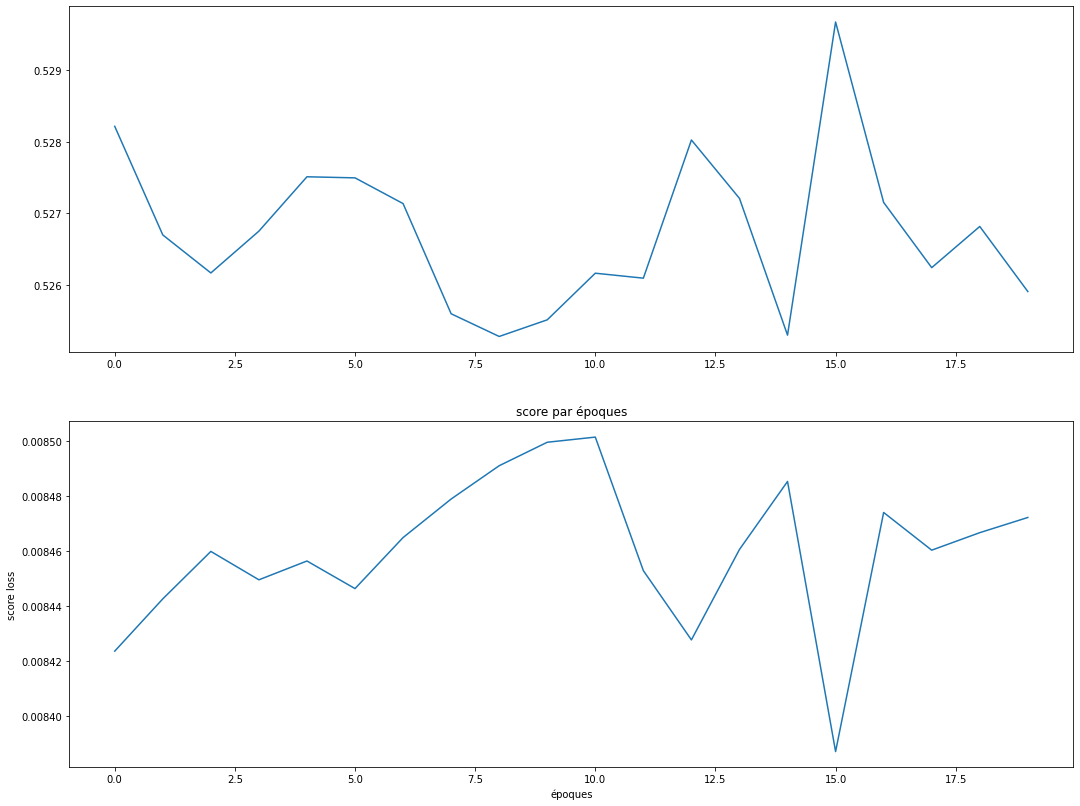

In [66]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(2,figsize=(18,14))
ax[0].plot([i for i in range(epochs)],train_loss)
ax[1].plot([i for i in range(epochs)],score_par_epoch)
ax[1].set(xlabel="époques",ylabel="score loss",title="score par époques")

In [79]:
#CEL=nn.CrossEntropyLoss()
#CEL(pred_output[0][0][0],output[0])
[torch.sum(-output[i]+pred_output[0][i][0]) for i in range(output.shape[0])]

[tensor(195.7910, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(197.4366, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(199.1156, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(200.9207, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(199.5107, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(197.2328, device='cuda:0', grad_fn=<SumBackward0>)]

In [ ]:
output.shape

In [ ]:
pickle.dump(pred_output,open('pred_output.pickle','wb'))

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
score_stat

In [ ]:
avg_train_loss

In [ ]:
validation=pickle.load(open('validation.pickle','rb'))
valid_dataloader = DataLoader(
            validation,
            sampler = RandomSampler(validation),
            batch_size = 8)

In [ ]:
#summa=torch.load("model_essai.pt")
device = torch.device("cuda")
summa=Summarizer(device=device)
summa.load_state_dict(torch.load("model_essai.pt"))
#summa

In [ ]:
summa.eval()
for step,batch in enumerate(valid_dataloader):
    if step==0:
        input_id_valid = batch[0].to(device)
        mask_valid = batch[1].to(device)
        clss_valid = batch[2].to(device)
        mask_cls_valid=batch[3].to(device)
        output_valid=batch[4].to(device)
        with torch.no_grad():
            pred=summa(x=input_id_valid,mask=mask_valid,clss=clss_valid,mask_cls=mask_cls_valid,output=output_valid)
            print(pred)
    #valid.append(batch)
    else:
        break



In [ ]:
f1=F1_score()
f1(pred,output_valid)

In [ ]:
import numpy as np
torch.tensor([1/(3/512),1/((512-3)/512)])


In [ ]:
CEL=torch.nn.CrossEntropyLoss(weight=torch.tensor([1/(3/512),1/((512-3)/512)]))
CEL()

In [ ]:
loss = nn.CrossEntropyLoss()
input = pred[0]#torch.randn(3, 5, requires_grad=True)
target = output_valid[0]#torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output